
<b>selct e poll metodi dei sistemi operativi </b><br>
The select() and poll() methods can be a powerful tool when you’re multiplexing network sockets. Specifically, these methods will indicate when a procedure will be safe to execute on an open file descriptor without any delays. For instance, a programmer can use these calls to know when there is data to be read on a socket. By delegating responsibility to select() and poll(), you don’t have to constantly check whether there is data to be read. Instead, select() and poll() can be placed in the background by the operating system and woken up when the event is satisfied or a specified timeout has elapsed. 

In [2]:
import socket
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.connect(('localhost', 50000))
s.sendall('Hello, world')
data = s.recv(1024)
s.close()
print ('Received', repr(data))

ConnectionRefusedError: [Errno 111] Connection refused

In [6]:

import socket

HOST = '127.0.0.1'  # The server's hostname or IP address
PORT = 6868        # The port used by the server

with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.connect((HOST, PORT))
    s.sendall(b'Hello, world')
    data = s.recv(1024)

print('Received', repr(data))

Received b'\x00'


 abstractmethod register(fileobj, events, data=None)

    Register a file object for selection, monitoring it for I/O events.
    
    fileobj is the file object to monitor. It may either be an integer file descriptor or an object with a fileno() method. events is a bitwise mask of events to monitor. data is an opaque object.

This returns a new SelectorKey instance, or raises a ValueError in case of invalid event mask or file descriptor, or KeyError if the file object is already registered.


class selectors.SelectorKey
    A SelectorKey is a namedtuple used to associate a file object to its underlying file descriptor, selected event mask and attached data. It is returned by several BaseSelector methods.

    fileobj
        File object registered.
    fd
        Underlying file descriptor.
    events
        Events that must be waited for on this file object.
    data
        Optional opaque data associated to this file object: for example, this could be used to store a per-client session ID.



In [110]:
'''https://realpython.com/python-sockets/#echo-client'''

import selectors,types
sel = selectors.DefaultSelector()
messages = [b'Message 1 from client.', b'Message 2 from client.']


def start_connections(host, port, num_conns):
    server_addr = (host, port)
    for i in range(0, num_conns):
        connid = i + 1
        print('starting connection', connid, 'to', server_addr)
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.setblocking(False)
        sock.connect_ex(server_addr)
        events = selectors.EVENT_READ | selectors.EVENT_WRITE
        data = types.SimpleNamespace(connid=connid,
                                     msg_total=sum(len(m) for m in messages),
                                     recv_total=0,
                                     messages=list(messages),
                                     outb=b'')
        selkey=sel.register(sock, events, data=data)
        print(selkey)

In [111]:
start_connections(HOST,PORT,1)

starting connection 1 to ('127.0.0.1', 6868)
SelectorKey(fileobj=<socket.socket fd=59, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 51874), raddr=('127.0.0.1', 6868)>, fd=59, events=3, data=namespace(connid=1, messages=[b'Message 1 from client.', b'Message 2 from client.'], msg_total=44, outb=b'', recv_total=0))


In [95]:
sel.select(timeout=None)

[(SelectorKey(fileobj=<socket.socket fd=54, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 51828), raddr=('127.0.0.1', 6868)>, fd=54, events=3, data=namespace(connid=1, messages=[b'Message 1 from client.', b'Message 2 from client.'], msg_total=44, outb=b'', recv_total=0)),
  3)]

In [87]:
def service_connection(key, mask):
    sock = key.fileobj
    data = key.data
    if mask & selectors.EVENT_READ:
        recv_data = sock.recv(1024)  # Should be ready to read
        if recv_data:
            if recv_data==b'\x00':
                return;
            print('received', repr(recv_data), 'from connection', data.connid)
            data.recv_total += len(recv_data)
        if not recv_data or data.recv_total == data.msg_total:
            print('closing connection', data.connid)
            sel.unregister(sock)
            sock.close()
    if mask & selectors.EVENT_WRITE:
        if not data.outb and data.messages:
            data.outb = data.messages.pop(0)
        if data.outb:
            print('sending', repr(data.outb), 'to connection', data.connid)
            sent = sock.send(data.outb)  # Should be ready to write
            data.outb = data.outb[sent:]


In [96]:
while 1:
    events = sel.select(timeout=10)
    for key, mask in events:
        if key.data is None:
            print("keidata none")
            accept_wrapper(key.fileobj)
        else:
            #print("ELSE")
            service_connection(key, mask)
            

received b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00' from connection 1
sending b'Message 1 from client.' to connection 1
sending b'Message 2 from client.' to connection 1
received b'DUE-ON\n' from connection 1
received b'DUE-OFF\n' from connection 1
received b'DUE-ON\n' from connection 1
received b'DUE-OFF\n' from connection 1
received b'DUE-ON\n' from connection 1
received b'UNO-OFF\n' from connection 1
received b'UNO-ON\n' from connection 1
received b'UNO-OFF\n' from connection 1
received b'UNO-ON\n' from connection 1
received b'1\n' from connection 1
received b'2\n' from connection 1
received b'DUE-OFF\n' from connection 1
received b'DUE-ON\n' from connection 1
received b'DUE-OFF\n' from connection 1
received b'DUE-ON\n' from connection 1
received b'DUE-OFF\n' from connection 1
received b'DUE-ON\n' from connection 1
received b'DUE-OFF\n' from connection 1
received b'DUE-ON\n' from connect

KeyboardInterrupt: 

In [97]:
sel.close()


KeyboardInterrupt: 

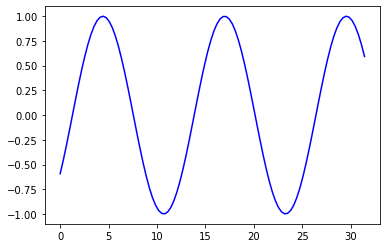

In [90]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 10*np.pi, 100)
y = np.sin(x)

plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
line1, = ax.plot(x, y, 'b-')

for phase in np.linspace(0, 10*np.pi, 100):
    line1.set_ydata(np.sin(0.5 * x + phase))
    fig.canvas.draw()